# Import library

In [1]:
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load Dataset

In [2]:
IMAGE_SIZE = 264
IMAGE_SIZE = 264
BATCH_SIZE = 32
Channels = 3
epochs = 30

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [5]:
len(dataset)

102

In [6]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(264, 264, 3)


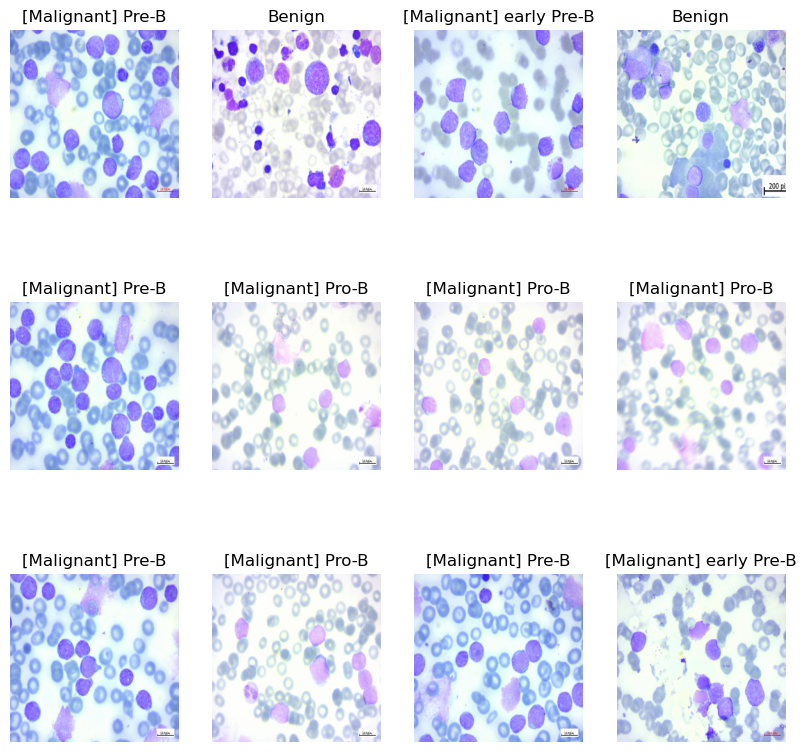

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  
                 
             

# Spliting Dataset

In [8]:
len(dataset)

102

In [9]:
#80% ==> training 
# 20% ==> 10% validation , 10% test

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [11]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)


In [12]:
len(train_ds)


81

In [13]:
len(test_ds)

11

In [14]:
len(val_ds)

10

# Data preprocessing

In [15]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

### Data Augmentation

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

# CNN Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = "Blood cell Cancer [ALL]"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor ='val_accuracy',
    mode ='max',
    save_best_only=True,
    verbose=2
  
)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 264, 264, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 264, 264, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 262, 262, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 131, 131, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 129, 129, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 64, 64, 64)         0         
 2D)                                                  

In [21]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [22]:
history = model.fit( 
    train_ds, 
    epochs= 5,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1
       )
 

Epoch 1/5
81/81 [==============================] - 395s 4s/step - loss: 1.6410 - accuracy: 0.5533 - val_loss: 0.5435 - val_accuracy: 0.7719
Epoch 2/5
81/81 [==============================] - 233s 3s/step - loss: 0.4994 - accuracy: 0.8051 - val_loss: 0.3270 - val_accuracy: 0.8687
Epoch 3/5
81/81 [==============================] - 246s 3s/step - loss: 0.4010 - accuracy: 0.8502 - val_loss: 0.2842 - val_accuracy: 0.8844
Epoch 4/5
81/81 [==============================] - 316s 4s/step - loss: 0.3421 - accuracy: 0.8739 - val_loss: 0.3498 - val_accuracy: 0.8625
Epoch 5/5
81/81 [==============================] - 254s 3s/step - loss: 0.2969 - accuracy: 0.8907 - val_loss: 0.2592 - val_accuracy: 0.9094


In [23]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 64s 549ms/step - loss: 0.2917 - accuracy: 0.8722


In [24]:
scores

[0.2917187511920929, 0.8721590638160706]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 81}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

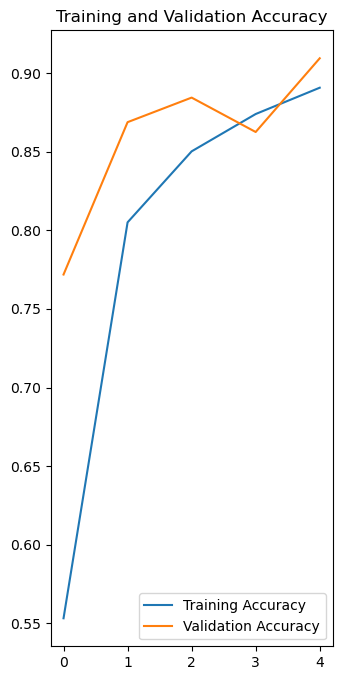

In [48]:

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:5],acc[:5],label='Training Accuracy')
plt.plot(range(epochs)[:5],val_acc[:5],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

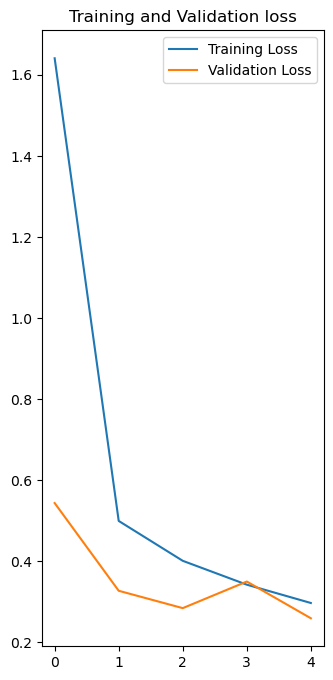

In [49]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:5],loss[:5],label='Training Loss')
plt.plot(range(epochs)[:5],val_loss[:5],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pre-B
1/1 [==============================] - 2s 2s/step
predicted label: [Malignant] Pre-B


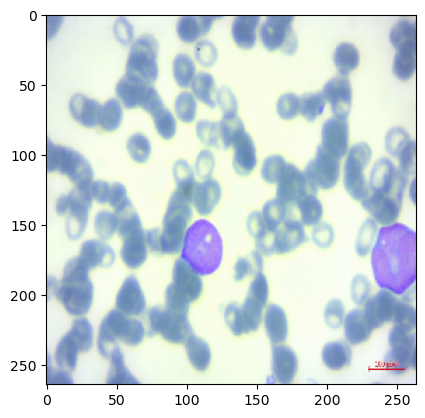

In [31]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


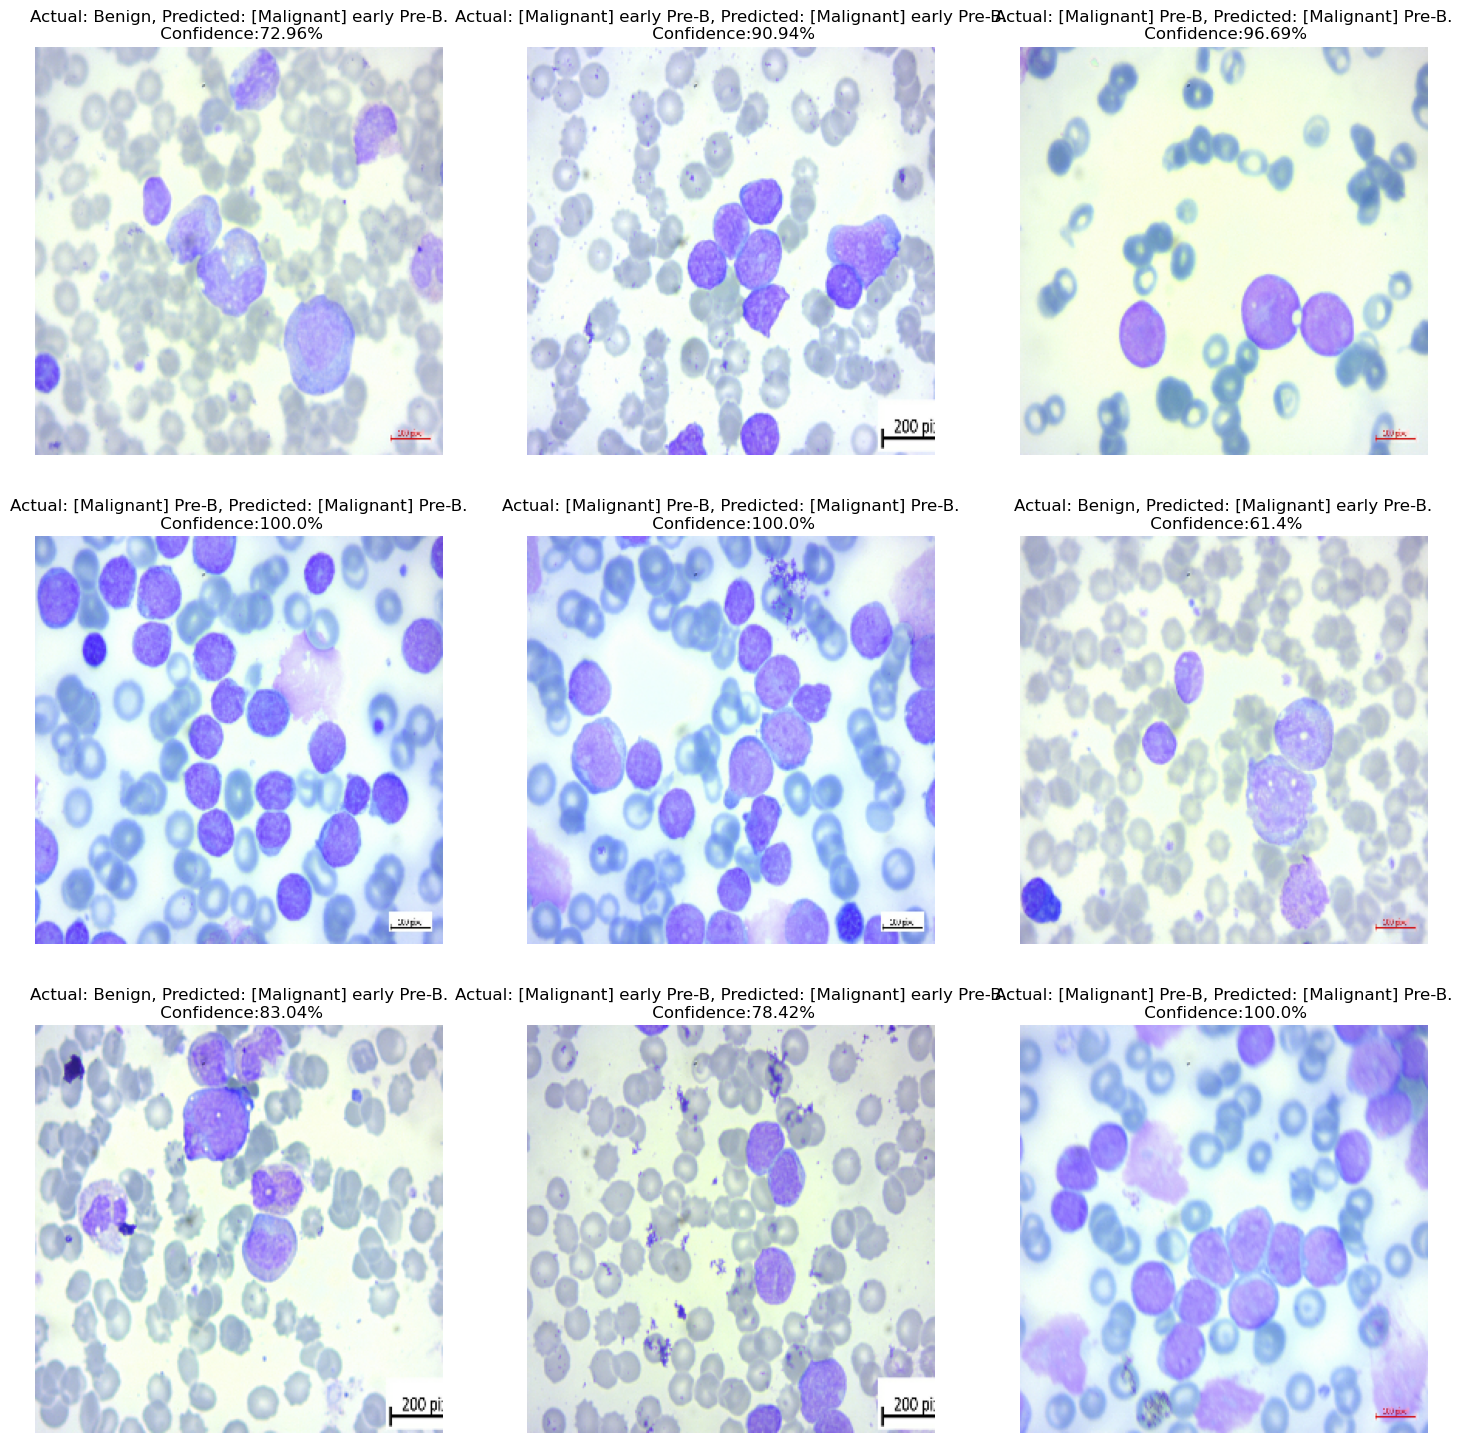

In [34]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

# confusion Matrix for CNN

In [35]:
y_pred = model.predict(test_ds)


11/11 [==============================] - 5s 494ms/step


In [36]:
y_pred_labels = np.argmax(y_pred, axis=1)


In [37]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)


In [38]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true_labels, y_pred_labels)


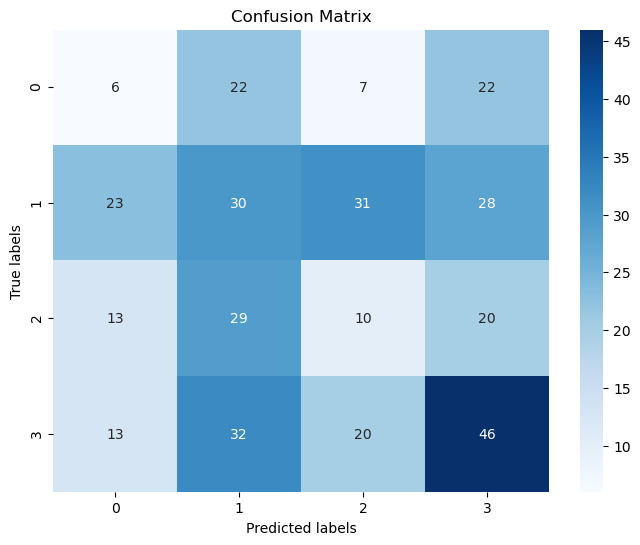

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [40]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


# Res NET model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, Input, BatchNormalization
from tensorflow.keras import Model

def resnet(input_shape, n_classes=4):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual Blocks
    residual = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    residual = BatchNormalization()(residual)
    residual = Conv2D(128, (3, 3), activation='relu', padding='same')(residual)
    residual = BatchNormalization()(residual)
    x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = MaxPooling2D((2, 2))(x)

    residual = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    residual = BatchNormalization()(residual)
    residual = Conv2D(256, (3, 3), activation='relu', padding='same')(residual)
    residual = BatchNormalization()(residual)
    x = Conv2D(256, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model




In [42]:
model = resnet((264, 264, 3), 4)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 264, 264, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 264, 264, 64  256        ['conv2d_5[0][0]']               
 alization)                     )                                                             

In [44]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
history = model.fit(
        train_ds, 
        epochs=5, 
        batch_size=BATCH_SIZE,
        validation_data=val_ds, 
        verbose=1)

Epoch 1/5


57/81 [====================>.........] - ETA: 17:18 - loss: 12.6355 - accuracy: 0.6809

KeyboardInterrupt: 

In [46]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 22s 1s/step - loss: 0.5720 - accuracy: 0.8185


In [47]:
scores

[0.5720421075820923, 0.8184523582458496]

In [48]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 162}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Accuracy')

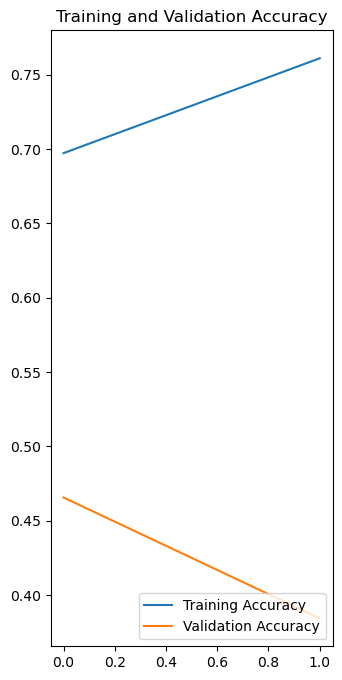

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],acc[:2],label='Training Accuracy')
plt.plot(range(epochs)[:2],val_acc[:2],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation loss')

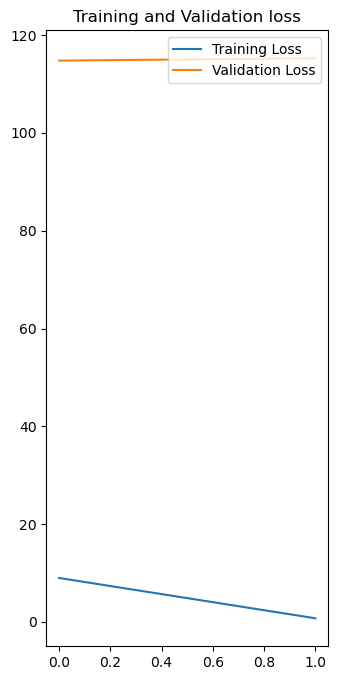

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs)[:2],loss[:2],label='Training Loss')
plt.plot(range(epochs)[:2],val_loss[:2],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')

First Image to predict
First image's actual label: [Malignant] Pre-B
1/1 [==============================] - 1s 1s/step
predicted label: [Malignant] Pre-B


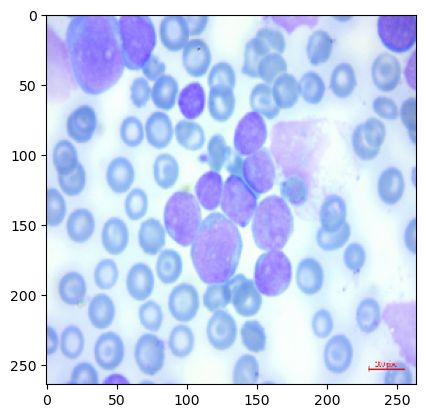

In [53]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]);

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 94ms/step


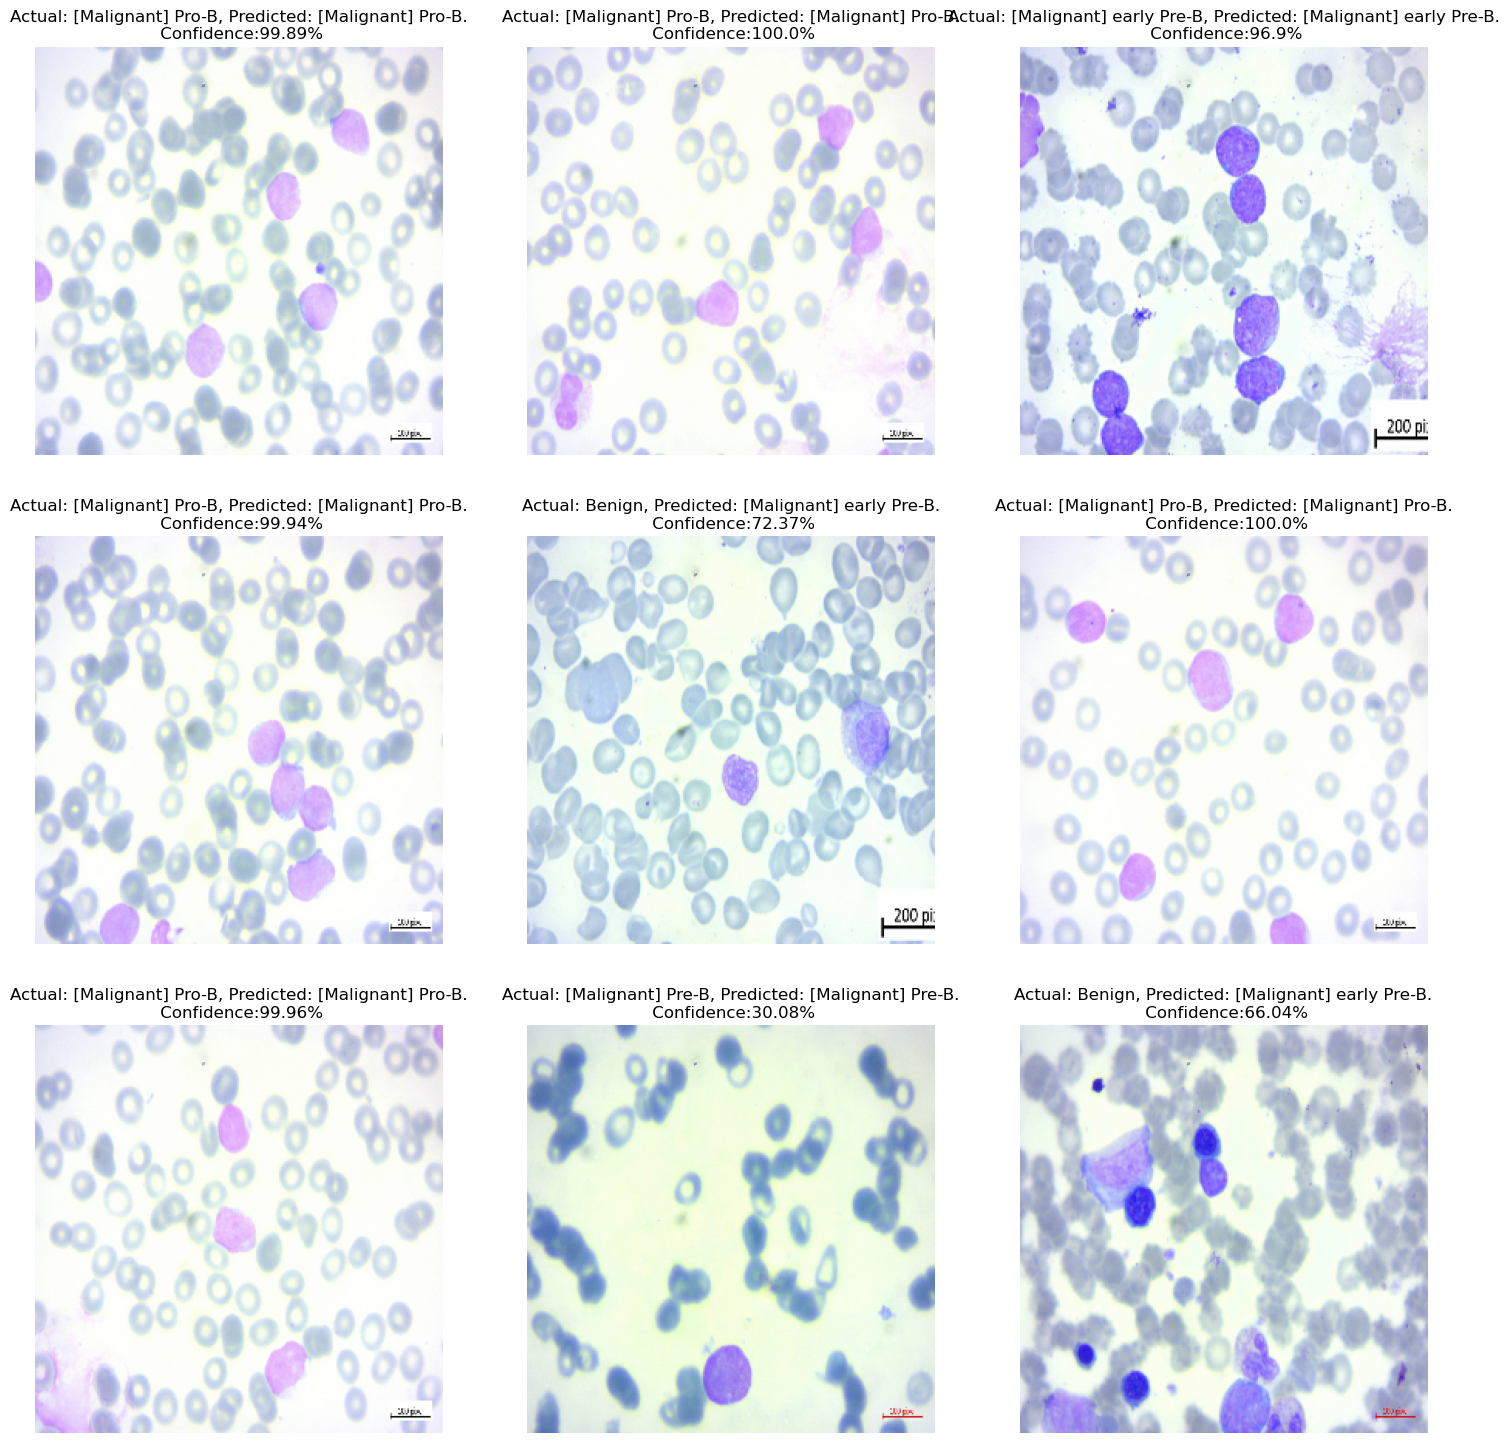

In [55]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence:{confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 92ms/step


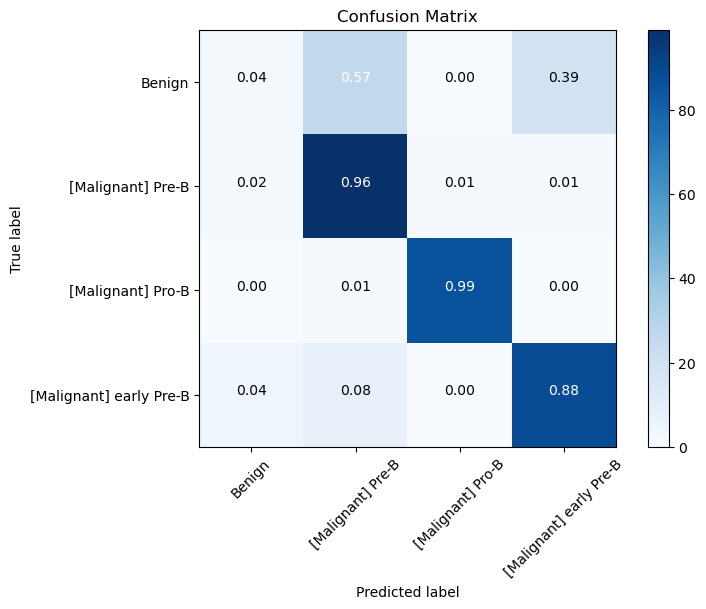

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

# Define class names
class_names = ['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

# Function to predict class and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

# Create a confusion matrix
num_classes = len(class_names)
confusion_mtx = np.zeros((num_classes, num_classes), dtype=np.int32)

# Iterate over test dataset and update the confusion matrix
for images, labels in test_ds:
    batch_size = images.shape[0]
    for i in range(batch_size):
        predicted_class, _ = predict(model, images[i])
        true_class = labels[i].numpy()
        confusion_mtx[true_class, predicted_class] += 1

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalize the confusion matrix
confusion_mtx_normalized = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix values as text
thresh = confusion_mtx_normalized.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_mtx_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [57]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


# AlexNET

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

input_shape = (IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(n_classes, activation='softmax')
])



In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 64, 64, 96)        34944     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 31, 31, 256)       614656    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 15, 15, 384)       885120    
                                                                 
 conv2d_16 (Conv2D)          (None, 15, 15, 384)      

In [60]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
history = model.fit(
        train_ds, 
        epochs=5, 
        batch_size=BATCH_SIZE,
        validation_data=val_ds, 
        verbose=1)

Epoch 1/5
162/162 [==============================] - 146s 893ms/step - loss: 17.5000 - accuracy: 0.2834 - val_loss: 1.3647 - val_accuracy: 0.2844
Epoch 2/5
162/162 [==============================] - 146s 899ms/step - loss: 1.3639 - accuracy: 0.3036 - val_loss: 1.3648 - val_accuracy: 0.2969
Epoch 3/5
162/162 [==============================] - 146s 899ms/step - loss: 1.3638 - accuracy: 0.2923 - val_loss: 1.3640 - val_accuracy: 0.2844
Epoch 4/5
162/162 [==============================] - 145s 894ms/step - loss: 1.3641 - accuracy: 0.2850 - val_loss: 1.3643 - val_accuracy: 0.2844
Epoch 5/5
162/162 [==============================] - 146s 899ms/step - loss: 1.3630 - accuracy: 0.2970 - val_loss: 1.3658 - val_accuracy: 0.2844


In [62]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 2s 109ms/step - loss: 1.3498 - accuracy: 0.3065


In [63]:
scores

[1.34980046749115, 0.306547611951828]